# Pipline for satellite image prediction an coordinate retrieval

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import os
import rasterio
import utils.utils as utils

from google.cloud import storage
from ultralytics import YOLO
from utils.geo_utils import get_true_pixel_masked, list_of_ships_and_coords_masked
from utils.image_processing import stretch_image, split_image
from rasterio.plot import show

## SETTINGS

In [19]:
MASK_THRESHOLD = 40
CLIP_MIN_MAX = (-30, 0)
FROM_GC_BUCKET = False


filename = 'new_mosaic.tif'
# filename = 'S1A_IW_GRDH_1SDV_20230215T034337_20230215T034402_047241_05AB34_5434_RES_10_NOT_CORRECTED.tif'
# filename = 'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20230215T162338_20230215T162403_047249_05AB7F_600C0000000000-0000000000.tif'

## get satellite image

In [20]:
# list files in gc bucket

# client = storage.Client()
# bucket = client.get_bucket(os.environ['DV_BUCKET'])

# for blob in bucket.list_blobs():
#     if blob.name.endswith('.tif'):
#         print(blob.name)

Image shape: (21698, 27959)


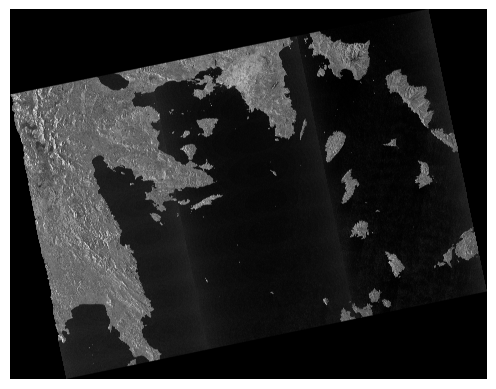

In [21]:
if FROM_GC_BUCKET:
    client = storage.Client()
    bucket = client.get_bucket(os.environ['DV_BUCKET'])
    with rasterio.open(utils.download_image(filename), 'r') as f:
        img = f.read(1)
        metadata = f.meta

else:
    with rasterio.open('data/download/' + filename, 'r') as f:
        img = f.read(1)
        metadata = f.meta

img = stretch_image(img, *CLIP_MIN_MAX)
print(f'Image shape: {img.shape}')

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## splitting images into a array of [640,640] tiles

In [23]:
# get max number of tiles
n_rows, n_columns = int(np.floor(img.shape[0] / 640)), int(np.floor(img.shape[1] / 640))

tiles = split_image(img)
print(tiles.shape)
# plot_tiles(tiles, n_rows, n_columns)

(33, 43, 640, 640)


## land masking


In [24]:
# PLEASE DO NOT UNCOMMENT THIS CELL
# THIS IS JUST FOR DEMONSTRATION PURPOSES


# list_of_means = [tiles[i][j].mean() for i in range(n_rows) for j in range(n_columns)]
# plt.hist(list_of_means, bins=100)
# plt.show()

# all_zero = np.zeros_like(tiles[0][0])
# for i in range(n_rows):
#     for j in range(n_columns):
#         if tiles[i][j].mean() > 35:
#             tiles[i][j] = np.zeros_like(tiles[i][j])

# combine = utils.combine_predictions_from_array(tiles, n_rows, n_columns)

# plt.figure(figsize=(10, 10))
# plt.imshow(combine, cmap='gray')
# plt.axis('off')
# plt.show()

## putting the tiles into a list to pass to YOLO and converting them to RGB


In [25]:
list_of_idx, tiles_list = utils.remove_land_tiles(tiles, 50)

The list contains 1061 tiles.


In [26]:
from ultralytics import YOLO

weights_path = 'runs/detect/train4/weights/best.torchscript'

model = YOLO(weights_path)

# predicting

In [27]:
batch_size = 128
print(f'Number of batches: {len(tiles_list) // batch_size + 1}')

Number of batches: 9


In [28]:
# batching the tiles_list and do the training
results = []
for i in range(len(tiles_list) // batch_size):
    results.extend(model(tiles_list[i * batch_size : (i + 1) * batch_size]))

# predicting the last batch
results.extend(model(tiles_list[(i + 1) * batch_size :]))

Loading runs/detect/train4/weights/best.torchscript for TorchScript inference...

0: 640x640 (no detections), 0.8ms
1: 640x640 (no detections), 0.8ms
2: 640x640 (no detections), 0.8ms
3: 640x640 (no detections), 0.8ms
4: 640x640 (no detections), 0.8ms
5: 640x640 (no detections), 0.8ms
6: 640x640 (no detections), 0.8ms
7: 640x640 (no detections), 0.8ms
8: 640x640 (no detections), 0.8ms
9: 640x640 (no detections), 0.8ms
10: 640x640 (no detections), 0.8ms
11: 640x640 (no detections), 0.8ms
12: 640x640 (no detections), 0.8ms
13: 640x640 (no detections), 0.8ms
14: 640x640 (no detections), 0.8ms
15: 640x640 (no detections), 0.8ms
16: 640x640 (no detections), 0.8ms
17: 640x640 (no detections), 0.8ms
18: 640x640 (no detections), 0.8ms
19: 640x640 (no detections), 0.8ms
20: 640x640 (no detections), 0.8ms
21: 640x640 (no detections), 0.8ms
22: 640x640 (no detections), 0.8ms
23: 640x640 (no detections), 0.8ms
24: 640x640 (no detections), 0.8ms
25: 640x640 (no detections), 0.8ms
26: 640x640 (no de

## view prediction

In [29]:
# fig, axes = plt.subplots(nrows=n_rows, ncols=n_columns, figsize=(15, 15))

# for i in range(n_rows):
#     for j in range(n_columns):
#         axes[i, j].imshow(results[i * n_columns + j].plot())
#         axes[i, j].axis('off')

# plt.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
# plt.show()

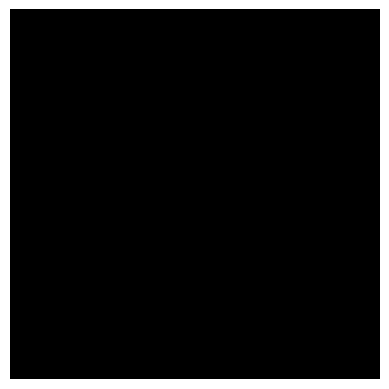

In [30]:
# view sample prediction
plt.imshow(results[0].plot())
plt.axis('off')
plt.show()

## get coordinates of all predictions and save them to file

In [31]:
metadata

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 27959,
 'height': 21698,
 'count': 1,
 'crs': CRS.from_epsg(32634),
 'transform': Affine(10.0, 0.0, 603738.5380772892,
        0.0, -10.0, 4247809.921514334)}

In [32]:
# Define the source and target CRS
source_crs = pyproj.CRS(metadata['crs'])
target_crs = pyproj.CRS("EPSG:4326")  # WGS84   EPSG:4326

# Create a transformer object
transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

In [33]:
ships_and_coords = list_of_ships_and_coords_masked(results, metadata['transform'], transformer, list_of_idx)

Total number of ships found: 211


In [34]:
import pandas as pd

csv_name = filename.split('/')[-1].split('.')[0]
pred_df = pd.DataFrame(ships_and_coords)
pred_df.to_csv(f'data/mask_result.csv', index=False)